In [2]:
RETRAIN = False

In [3]:
!pip install xmltodict

In [5]:
import os   
import cv2
import torch
import argparse
import xmltodict
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

class Data:
    def __init__(self, img_path, target_path, transforms = None):
        with open(target_path, 'r') as f:
            lines = f.readlines()
            self.img_list = [os.path.join(img_path, i.split()[0]) for i in lines]
            self.label_list = [i.split()[1] for i in lines]
            self.transforms = transforms
    
    def __getitem__(self, index):
        try:
            img_path = self.img_list[index]
            img = Image.open(img_path)
            img = self.transforms(img)
            label = self.label_list[index]
        except:
            return None
        return img, label
    
    def __len__(self):
        return len(self.label_list)

In [6]:
def imshow(train_loader):
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    img = torchvision.utils.make_grid(images)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=2, init_weights=False):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 48, 11, 4, 2), 
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, 2), 
        nn.Conv2d(48, 128, kernel_size=5, padding=2), 
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),        
        nn.Conv2d(128, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(128 * 6 * 6, 2048),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(2048, 2048),
      nn.ReLU(inplace=True),
      nn.Linear(2048, num_classes),
    )
    if init_weights:
      self._initialize_weights()
  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      return self.classifier(x)

  def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, 0.01)
              nn.init.constant_(m.bias, 0) 


class mAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.input_channel = 3
        self.num_output = num_classes
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channel, out_channels= 16, kernel_size= 11, stride= 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels= 16, out_channels= 20, kernel_size= 5, stride= 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels= 20, out_channels= 30, kernel_size= 3, stride= 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(30*3*3, out_features=48),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Linear(in_features=48, out_features=2)
        )

    def forward(self, x):
        x = self.layer3(self.layer2(self.layer1(x)))
        x = x.view(x.size(0), -1)
        x = self.layer5(self.layer4(x))
        m = nn.Softmax(dim=1)
        return m(x)

In [8]:
def train(epoch, img_path, target_path, transform, net, criterion, device):
    train_dataset = Data(img_path, target_path, transform)
    train_loader = DataLoader(train_dataset, batch_size=64, \
            shuffle=True, num_workers=0,drop_last=False, collate_fn=collate_fn)
    for ep in range(epoch):  
        if ep >= 12:
            learning_rate = 0.0025
        elif ep >= 6:
            learning_rate = 0.005
        else:
            learning_rate = 0.01
        running_loss = 0.0
        print("Epoch {}.".format(ep+1))
        for i, data in enumerate(train_loader,1):
            inputs, labels = data
            labels = list(map(int, labels))
            labels = torch.Tensor(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print("Epoch {}.\tBatch {}.\tLoss = {:.3f}.".format(ep+1, i+1, running_loss))
            if i % 2000 == 1999:    # 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')


In [9]:
def test(img_path, target_path, transform, net, device):
    print("\nTesting starts now...")
    test_dataset = Data(img_path, target_path, transform)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, \
                            num_workers=0, collate_fn=collate_fn)
    correct = 0
    total = 0
    item = 1
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            print("Testing on batch {}".format(item))
            labels = list(map(int, labels))
            labels = torch.Tensor(labels)
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            item += 1
    return (correct/total)


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),  # normalize to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


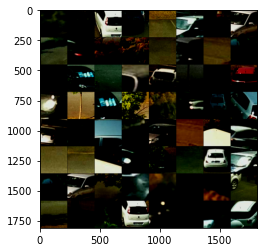

In [11]:
train_dataset = Data("CNRPark-Patches-150x150/", "splits/CNRParkAB/even.txt", transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
imgs, labels = train_loader.__iter__().__next__()
imshow(train_loader)

In [12]:
net = mAlexNet().to(device)
criterion = nn.CrossEntropyLoss()

In [13]:
if RETRAIN:
    train(18, "CNRPark-Patches-150x150/", "splits/CNRParkAB/even.txt", transform, net, criterion, device)
    PATH = 'model.pth'
    torch.save(net.state_dict(), PATH)
    net.load_state_dict(torch.load(PATH))
else:
    PATH = './model.pth'
    net.load_state_dict(torch.load(PATH))

In [ ]:
accuracy = test("CNRPark-Patches-150x150/", "splits/CNRParkAB/odd.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format(("splits/CNRParkAB/even.txt").split('.')[0], ("splits/CNRParkAB/odd.txt").split('.')[0], accuracy))

In [29]:
listi = []
names = []
for root, dirs, files in os.walk("PKLot/PKLot/PKLotSegmented/PUC/Cloudy/2012-09-12/"):
  for fil in files:
    if '2012-09-12_08_00_11' in fil:
      names.append(fil)
      if 'Empty' in root:
        listi.append((transform(Image.open(root + '/' + fil)), '0'))
      else:
        listi.append((transform(Image.open(root + '/' + fil)), '1'))
        
dl = DataLoader(listi, batch_size=1, shuffle=True, drop_last=False)

In [30]:
preds = []
correct = 0
total = 0
item = 1
for a in dl:
  images, labels = a
  labels = list(map(int, labels))
  labels = torch.Tensor(labels)
  images = images.to(device)
  labels = labels.to(device)

  outputs = net(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
  item += 1
  preds.append(predicted)

In [31]:
accuracy = correct/total
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format(("splits/CNRParkAB/even.txt").split('.')[0], ("splits/CNRParkAB/odd.txt").split('.')[0], accuracy))


The accuracy of training on 'splits/CNRParkAB/even' and testing on 'splits/CNRParkAB/odd' is 0.900.


In [21]:
with open('PKLot/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_08_00_11.xml') as f:
  content=f.read()
  d = xmltodict.parse(content)
  coord = []
  for fil in names:
    coo = d['parking']['space'][int(fil[-7:-4])-1]['contour']['point']
    coord.append([[int(x['@x']), int(x['@y'])] for x in coo])

In [28]:
img = cv2.imread("PKLot/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_08_00_11.jpg")

for i, co in enumerate(coord):
  pts = np.array(co, np.int32)
  pts = pts.reshape((-1,1,2))
  if listi[i][1] == '0':
    c = (0,255,255)
  else:
    c = (255, 0, 0)
  cv2.polylines(img,[pts],True,c, 2)

while(1):
     
    cv2.imshow('image', img)
    if cv2.waitKey(20) & 0xFF == 27:
        break
cv2.destroyAllWindows()